# Data Cleaning & Missing Data Analysis

**Goal**: Deep-dive into both datasets (yield & climate) to understand all data quality issues before deciding how to handle them.

**Outline**:
1. Load both raw datasets
2. **Yield table** — missing values per column, per department, per year; recoverability; outliers; consistency checks
3. **Climate table** — missing values, coverage gaps, data quality (negative precip), completeness per department/year
4. **Department mismatch** — detailed comparison of department names between the two tables
5. **Cross-table join analysis** — what happens when we merge; which rows gain NaN and why
6. **Summary of all issues** — table of decisions to make together

---
## 1. Load both raw datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
pd.set_option("display.max_rows", 120)

YIELD_PATH = "../raw_data/barley_yield_from_1982.csv"
CLIMATE_PATH = "../raw_data/climate_data_from_1982.parquet"

# Load
df_yield_raw = pd.read_csv(YIELD_PATH, sep=";")
df_climate_raw = pd.read_parquet(CLIMATE_PATH)

print("Yield raw shape:", df_yield_raw.shape)
print("Climate raw shape:", df_climate_raw.shape)

Yield raw shape: (3583, 6)
Climate raw shape: (13540116, 7)


In [2]:
# Clean column names
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^a-z0-9_]", "", regex=True)
    )
    return df

df_yield = clean_cols(df_yield_raw)
df_yield = df_yield.rename(columns={"department": "nom_dep"})
df_yield["year"] = pd.to_numeric(df_yield["year"], errors="coerce")
df_yield["yield"] = pd.to_numeric(df_yield["yield"], errors="coerce")
df_yield["area"] = pd.to_numeric(df_yield["area"], errors="coerce")
df_yield["production"] = pd.to_numeric(df_yield["production"], errors="coerce")

df_climate = clean_cols(df_climate_raw)
df_climate["time"] = pd.to_datetime(df_climate["time"])

print("Yield columns:", df_yield.columns.tolist())
print("Climate columns:", df_climate.columns.tolist())
display(df_yield.head())
display(df_climate.head())

Yield columns: ['unnamed_0', 'nom_dep', 'year', 'yield', 'area', 'production']
Climate columns: ['scenario', 'nom_dep', 'code_dep', 'time', 'year', 'metric', 'value']


,unnamed_0,nom_dep,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.0
1,83,Ain,1983,NaN,14500.0,38400.0
2,84,Ain,1984,4.82258,15500.0,74750.0
3,85,Ain,1985,4.19677,15500.0,65050.0
4,86,Ain,1986,3.59845,12900.0,46420.0


,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,276.292267
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,275.092407
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,276.418518
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,278.893372
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,278.887207


---
## 2. Yield Table — Deep Missing Data Analysis

### 2.1 Overall missing values per column

In [3]:
print("YIELD TABLE — MISSING VALUES PER COLUMN")
print("=" * 60)
for col in df_yield.columns:
    n_miss = df_yield[col].isna().sum()
    pct = 100 * n_miss / len(df_yield)
    print(f"  {col:15s}: {n_miss:4d} missing  ({pct:5.2f}%)")

print(f"\nTotal rows: {len(df_yield)}")
print(f"Rows with ANY missing: {df_yield.isna().any(axis=1).sum()}")
print(f"Rows with ALL of yield/area/production missing: {(df_yield[['yield','area','production']].isna().all(axis=1)).sum()}")

YIELD TABLE — MISSING VALUES PER COLUMN
  unnamed_0      :    0 missing  ( 0.00%)
  nom_dep        :    0 missing  ( 0.00%)
  year           :    0 missing  ( 0.00%)
  yield          :  247 missing  ( 6.89%)
  area           :  115 missing  ( 3.21%)
  production     :  122 missing  ( 3.40%)

Total rows: 3583
Rows with ANY missing: 250
Rows with ALL of yield/area/production missing: 115


### 2.2 Missing values overlap (yield vs area vs production)

In [4]:
miss_yield = df_yield["yield"].isna()
miss_area = df_yield["area"].isna()
miss_prod = df_yield["production"].isna()

print("OVERLAP OF MISSING VALUES")
print("=" * 60)
print(f"  yield NaN only (area & prod present) : {(miss_yield & ~miss_area & ~miss_prod).sum()}")
print(f"  yield NaN + area NaN + prod NaN      : {(miss_yield & miss_area & miss_prod).sum()}")
print(f"  yield NaN + area NaN (prod present)  : {(miss_yield & miss_area & ~miss_prod).sum()}")
print(f"  yield NaN + prod NaN (area present)  : {(miss_yield & ~miss_area & miss_prod).sum()}")
print(f"  area NaN only (yield present)        : {(~miss_yield & miss_area).sum()}")
print(f"  production NaN only (yield present)  : {(~miss_yield & miss_prod).sum()}")

# Crosstab for clarity
df_yield["yield_miss"] = miss_yield.map({True: "yield NaN", False: "yield OK"})
df_yield["area_miss"] = miss_area.map({True: "area NaN", False: "area OK"})
df_yield["prod_miss"] = miss_prod.map({True: "prod NaN", False: "prod OK"})

print("\nCrosstab: yield_miss vs area_miss")
display(pd.crosstab(df_yield["yield_miss"], df_yield["area_miss"], margins=True))
print("\nCrosstab: yield_miss vs prod_miss")
display(pd.crosstab(df_yield["yield_miss"], df_yield["prod_miss"], margins=True))

# Clean up temp columns
df_yield.drop(columns=["yield_miss", "area_miss", "prod_miss"], inplace=True)

OVERLAP OF MISSING VALUES
  yield NaN only (area & prod present) : 128
  yield NaN + area NaN + prod NaN      : 115
  yield NaN + area NaN (prod present)  : 0
  yield NaN + prod NaN (area present)  : 4
  area NaN only (yield present)        : 0
  production NaN only (yield present)  : 3

Crosstab: yield_miss vs area_miss


area_miss,area NaN,area OK,All
yield_miss,,,
yield NaN,115,132,247
yield OK,0,3336,3336
All,115,3468,3583



Crosstab: yield_miss vs prod_miss


prod_miss,prod NaN,prod OK,All
yield_miss,,,
yield NaN,119,128,247
yield OK,3,3333,3336
All,122,3461,3583


### 2.3 Recoverability: can we compute yield = production / area?

In [5]:
recoverable = miss_yield & ~miss_area & ~miss_prod & (df_yield["area"] > 0)
not_recoverable = miss_yield & ~recoverable

print("YIELD RECOVERABILITY")
print("=" * 60)
print(f"  Total missing yield          : {miss_yield.sum()}")
print(f"  Recoverable (prod/area)      : {recoverable.sum()}")
print(f"  NOT recoverable              : {not_recoverable.sum()}")

# Show the recoverable rows to verify they look reasonable
if recoverable.sum() > 0:
    sample = df_yield[recoverable].copy()
    sample["yield_computed"] = sample["production"] / sample["area"]
    print(f"\nSample of recoverable rows (computed yield = production / area):")
    display(sample[["nom_dep", "year", "yield", "area", "production", "yield_computed"]].head(15))
    print(f"\nComputed yield stats:")
    display(sample["yield_computed"].describe())

YIELD RECOVERABILITY
  Total missing yield          : 247
  Recoverable (prod/area)      : 125
  NOT recoverable              : 122

Sample of recoverable rows (computed yield = production / area):


,nom_dep,year,yield,area,production,yield_computed
1,Ain,1983,NaN,14500.0,38400.0,2.648276
16,Ain,1998,NaN,9500.0,60050.0,6.321053
39,Aisne,1984,NaN,53500.0,382450.0,7.148598
169,Alpes_Maritimes,2003,NaN,55.0,137.5,2.500000
187,Ardeche,1984,NaN,4057.0,19658.0,4.845452
200,Ardeche,1997,NaN,2332.0,3731.2,1.600000
206,Ardeche,2003,NaN,2550.0,5754.0,2.256471
386,Aveyron,1998,NaN,28336.0,142927.4,5.044022
432,Bas_Rhin,2007,NaN,3596.0,17937.2,4.988098
459,Bouches_du_Rhone,1997,NaN,950.0,1896.0,1.995789



Computed yield stats:


count    125.000000
mean       5.194850
std        2.255549
min        1.396133
25%        3.267802
50%        4.975000
75%        7.231174
max        9.434165
Name: yield_computed, dtype: float64

### 2.4 Consistency check: yield vs production/area (when all three present)

In [6]:
# When yield, area, production are all present, does yield ~= production/area?
mask_all_present = ~miss_yield & ~miss_area & ~miss_prod & (df_yield["area"] > 0)
check = df_yield[mask_all_present].copy()
check["yield_computed"] = check["production"] / check["area"]
check["diff"] = (check["yield"] - check["yield_computed"]).abs()
check["diff_pct"] = 100 * check["diff"] / check["yield"].replace(0, np.nan)

print("CONSISTENCY: yield vs production/area")
print("=" * 60)
print(f"Rows checked: {len(check)}")
print(f"\nAbsolute difference stats:")
display(check["diff"].describe())
print(f"\nRows with >1% discrepancy: {(check['diff_pct'] > 1).sum()}")
print(f"Rows with >5% discrepancy: {(check['diff_pct'] > 5).sum()}")
print(f"Rows with >10% discrepancy: {(check['diff_pct'] > 10).sum()}")

if (check["diff_pct"] > 5).sum() > 0:
    print("\nRows with >5% discrepancy:")
    display(check[check["diff_pct"] > 5][["nom_dep", "year", "yield", "area", "production", "yield_computed", "diff_pct"]].sort_values("diff_pct", ascending=False).head(20))

CONSISTENCY: yield vs production/area
Rows checked: 3333

Absolute difference stats:


count    3.333000e+03
mean     1.170071e-03
std      6.127822e-03
min      0.000000e+00
25%      1.875167e-07
50%      1.981424e-06
75%      3.562003e-06
max      5.000000e-02
Name: diff, dtype: float64


Rows with >1% discrepancy: 5
Rows with >5% discrepancy: 0
Rows with >10% discrepancy: 0


### 2.5 Missing yield by YEAR

MISSING BY YEAR


,year,total_depts,yield_missing,area_missing,prod_missing,yield_miss_pct
0,1982,97,9,3,3,9.3
1,1983,97,11,3,3,11.3
2,1984,97,9,3,5,9.3
3,1985,97,3,3,3,3.1
4,1986,97,6,3,3,6.2
5,1987,97,5,3,4,5.2
6,1988,97,5,3,3,5.2
7,1989,97,5,3,3,5.2
8,1990,97,11,3,3,11.3
9,1991,97,4,3,3,4.1


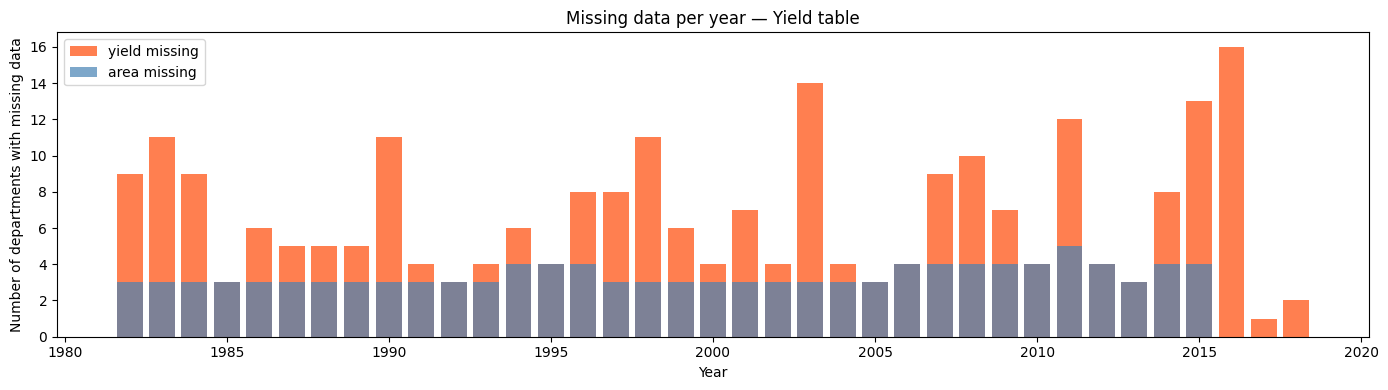

In [7]:
# Missing yield by year
year_stats = df_yield.groupby("year").agg(
    total_depts=("nom_dep", "count"),
    yield_missing=("yield", lambda x: x.isna().sum()),
    area_missing=("area", lambda x: x.isna().sum()),
    prod_missing=("production", lambda x: x.isna().sum()),
).reset_index()
year_stats["yield_miss_pct"] = (100 * year_stats["yield_missing"] / year_stats["total_depts"]).round(1)

print("MISSING BY YEAR")
print("=" * 60)
display(year_stats)

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(year_stats["year"], year_stats["yield_missing"], color="coral", label="yield missing")
ax.bar(year_stats["year"], year_stats["area_missing"], color="steelblue", alpha=0.7, label="area missing")
ax.set_xlabel("Year")
ax.set_ylabel("Number of departments with missing data")
ax.set_title("Missing data per year — Yield table")
ax.legend()
plt.tight_layout()
plt.show()

### 2.6 Missing yield by DEPARTMENT

In [8]:
dep_stats = df_yield.groupby("nom_dep").agg(
    total_years=("year", "count"),
    yield_missing=("yield", lambda x: x.isna().sum()),
    area_missing=("area", lambda x: x.isna().sum()),
    prod_missing=("production", lambda x: x.isna().sum()),
    yield_mean=("yield", "mean"),
    area_mean=("area", "mean"),
).reset_index()
dep_stats["yield_miss_pct"] = (100 * dep_stats["yield_missing"] / dep_stats["total_years"]).round(1)
dep_stats = dep_stats.sort_values("yield_missing", ascending=False)

print("MISSING BY DEPARTMENT (sorted by yield_missing)")
print("=" * 60)
display(dep_stats.head(30))

# Departments with >20% missing yield
high_miss = dep_stats[dep_stats["yield_miss_pct"] > 20]
print(f"\nDepartments with >20% missing yield: {len(high_miss)}")
display(high_miss[["nom_dep", "total_years", "yield_missing", "yield_miss_pct", "yield_mean", "area_mean"]])

MISSING BY DEPARTMENT (sorted by yield_missing)


,nom_dep,total_years,yield_missing,area_missing,prod_missing,yield_mean,area_mean,yield_miss_pct
44,Hauts_de_Seine,37,37,32,35,NaN,0.000000,100.0
71,Paris,34,34,34,34,NaN,NaN,100.0
82,Seine_SeineOise,34,34,34,34,NaN,NaN,100.0
72,Pas_de_Calais,37,9,0,0,7.243320,58919.513514,24.3
84,Somme,37,8,0,0,7.295618,51025.405405,21.6
81,Seine_Saint_Denis,37,7,4,5,6.245381,19.303030,18.9
19,Corse_du_Sud,37,7,7,7,2.066667,40.600000,18.9
69,Oise,37,6,0,0,7.052062,32730.108108,16.2
80,Seine_Maritime,37,6,0,0,7.136843,33175.027027,16.2
29,Eure_et_Loir,37,4,0,0,6.985760,52122.729730,10.8



Departments with >20% missing yield: 5


,nom_dep,total_years,yield_missing,yield_miss_pct,yield_mean,area_mean
44,Hauts_de_Seine,37,37,100.0,NaN,0.000000
71,Paris,34,34,100.0,NaN,NaN
82,Seine_SeineOise,34,34,100.0,NaN,NaN
72,Pas_de_Calais,37,9,24.3,7.243320,58919.513514
84,Somme,37,8,21.6,7.295618,51025.405405


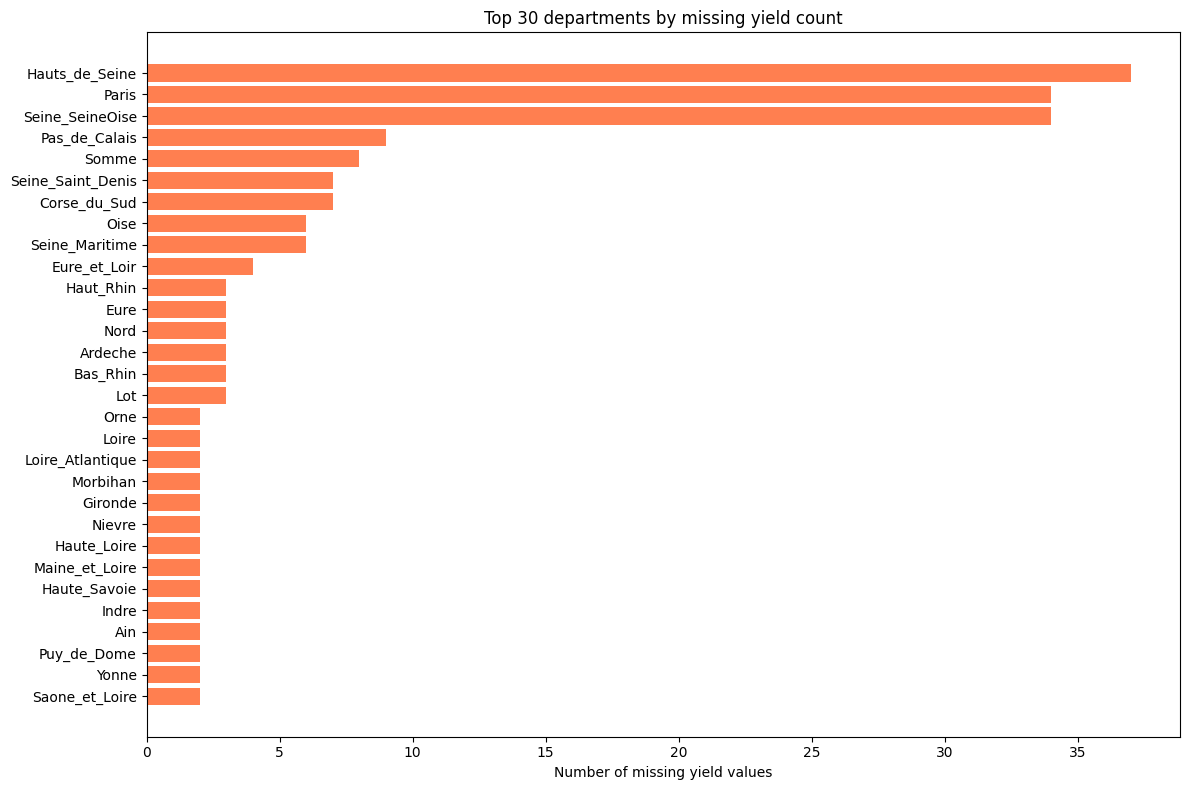

In [9]:
# Visualize: top 30 departments by missing yield count
top30 = dep_stats.head(30)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top30["nom_dep"], top30["yield_missing"], color="coral")
ax.set_xlabel("Number of missing yield values")
ax.set_title("Top 30 departments by missing yield count")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 2.7 Departments with ZERO yield data

In [10]:
# Departments where yield is ALWAYS missing
zero_yield_depts = dep_stats[dep_stats["yield_missing"] == dep_stats["total_years"]]
print(f"Departments with ALL yield missing: {len(zero_yield_depts)}")
if len(zero_yield_depts) > 0:
    display(zero_yield_depts[["nom_dep", "total_years", "yield_missing", "area_mean"]])

# Departments where yield is NEVER missing
full_yield_depts = dep_stats[dep_stats["yield_missing"] == 0]
print(f"\nDepartments with NO missing yield: {len(full_yield_depts)}")

Departments with ALL yield missing: 3


,nom_dep,total_years,yield_missing,area_mean
44,Hauts_de_Seine,37,37,0.0
71,Paris,34,34,NaN
82,Seine_SeineOise,34,34,NaN



Departments with NO missing yield: 26


### 2.8 Yield outlier check

YIELD VALUE DISTRIBUTION


count    3336.000000
mean        5.212239
std         1.369354
min         0.813560
25%         4.242530
50%         5.261230
75%         6.225615
max         8.400000
Name: yield, dtype: float64


IQR bounds: [1.27, 9.20]
Outliers (IQR method): 9 (0.3%)

Outlier rows:


,nom_dep,year,yield,area,production
150,Alpes_Maritimes,1984,0.81356,354.0,288.0
708,Corse_du_Sud,1987,1.00000,50.0,50.0
2788,Pyrenees_Orientales,1998,1.00000,70.0,70.0
155,Alpes_Maritimes,1989,1.04375,160.0,167.0
2787,Pyrenees_Orientales,1997,1.12500,80.0,90.0
2150,Lozere,1986,1.15065,4308.0,4957.0
703,Corse_du_Sud,1982,1.20000,100.0,120.0
2772,Pyrenees_Orientales,1982,1.20000,180.0,216.0
2773,Pyrenees_Orientales,1983,1.24000,150.0,186.0


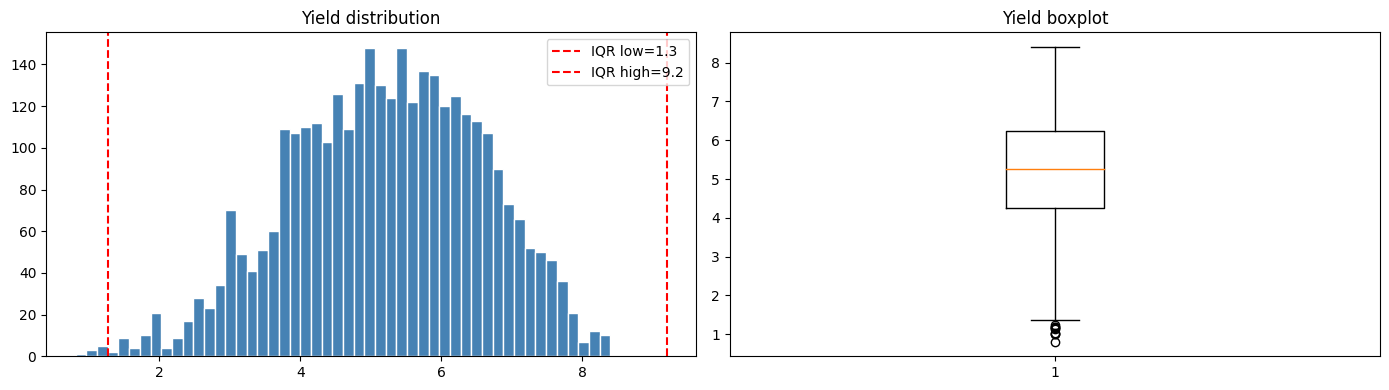

In [11]:
valid_yield = df_yield.dropna(subset=["yield"])

print("YIELD VALUE DISTRIBUTION")
print("=" * 60)
display(valid_yield["yield"].describe())

# IQR method for outliers
q1, q3 = valid_yield["yield"].quantile([0.25, 0.75])
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
outliers = valid_yield[(valid_yield["yield"] < low) | (valid_yield["yield"] > high)]

print(f"\nIQR bounds: [{low:.2f}, {high:.2f}]")
print(f"Outliers (IQR method): {len(outliers)} ({100*len(outliers)/len(valid_yield):.1f}%)")

if len(outliers) > 0:
    print("\nOutlier rows:")
    display(outliers[["nom_dep", "year", "yield", "area", "production"]].sort_values("yield"))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(valid_yield["yield"], bins=50, color="steelblue", edgecolor="white")
axes[0].axvline(low, color="red", ls="--", label=f"IQR low={low:.1f}")
axes[0].axvline(high, color="red", ls="--", label=f"IQR high={high:.1f}")
axes[0].set_title("Yield distribution")
axes[0].legend()
axes[1].boxplot(valid_yield["yield"], vert=True)
axes[1].set_title("Yield boxplot")
plt.tight_layout()
plt.show()

### 2.9 Area = 0 or very small (suspect rows)

In [12]:
# Rows where area = 0 or production = 0
zero_area = df_yield[df_yield["area"] == 0]
zero_prod = df_yield[df_yield["production"] == 0]

print(f"Rows with area = 0: {len(zero_area)}")
if len(zero_area) > 0:
    display(zero_area[["nom_dep", "year", "yield", "area", "production"]])

print(f"\nRows with production = 0: {len(zero_prod)}")
if len(zero_prod) > 0:
    display(zero_prod[["nom_dep", "year", "yield", "area", "production"]].head(20))

# Very small areas
small_area = df_yield[(df_yield["area"] > 0) & (df_yield["area"] < 100)]
print(f"\nRows with 0 < area < 100 (very small): {len(small_area)}")
if len(small_area) > 0:
    display(small_area[["nom_dep", "year", "yield", "area", "production"]].head(20))

Rows with area = 0: 7


,nom_dep,year,yield,area,production
1660,Hauts_de_Seine,2014,NaN,0.0,0.0
1661,Hauts_de_Seine,2015,NaN,0.0,0.0
1662,Hauts_de_Seine,2016,NaN,0.0,NaN
1663,Hauts_de_Seine,2017,NaN,0.0,NaN
1664,Hauts_de_Seine,2018,NaN,0.0,NaN
3064,Seine_Saint_Denis,2015,NaN,0.0,0.0
3067,Seine_Saint_Denis,2018,NaN,0.0,NaN



Rows with production = 0: 3


,nom_dep,year,yield,area,production
1660,Hauts_de_Seine,2014,NaN,0.0,0.0
1661,Hauts_de_Seine,2015,NaN,0.0,0.0
3064,Seine_Saint_Denis,2015,NaN,0.0,0.0



Rows with 0 < area < 100 (very small): 124


,nom_dep,year,yield,area,production
165,Alpes_Maritimes,1999,4.00000,95.0,380.0
166,Alpes_Maritimes,2000,4.00000,90.0,360.0
167,Alpes_Maritimes,2001,3.70000,90.0,333.0
168,Alpes_Maritimes,2002,4.00000,60.0,240.0
169,Alpes_Maritimes,2003,NaN,55.0,137.5
170,Alpes_Maritimes,2004,4.00000,55.0,220.0
171,Alpes_Maritimes,2005,4.00000,55.0,220.0
172,Alpes_Maritimes,2006,4.00000,45.0,180.0
173,Alpes_Maritimes,2007,3.50000,40.0,140.0
174,Alpes_Maritimes,2008,3.80000,22.0,83.6


### 2.10 Heatmap: missing yield by (department x year)

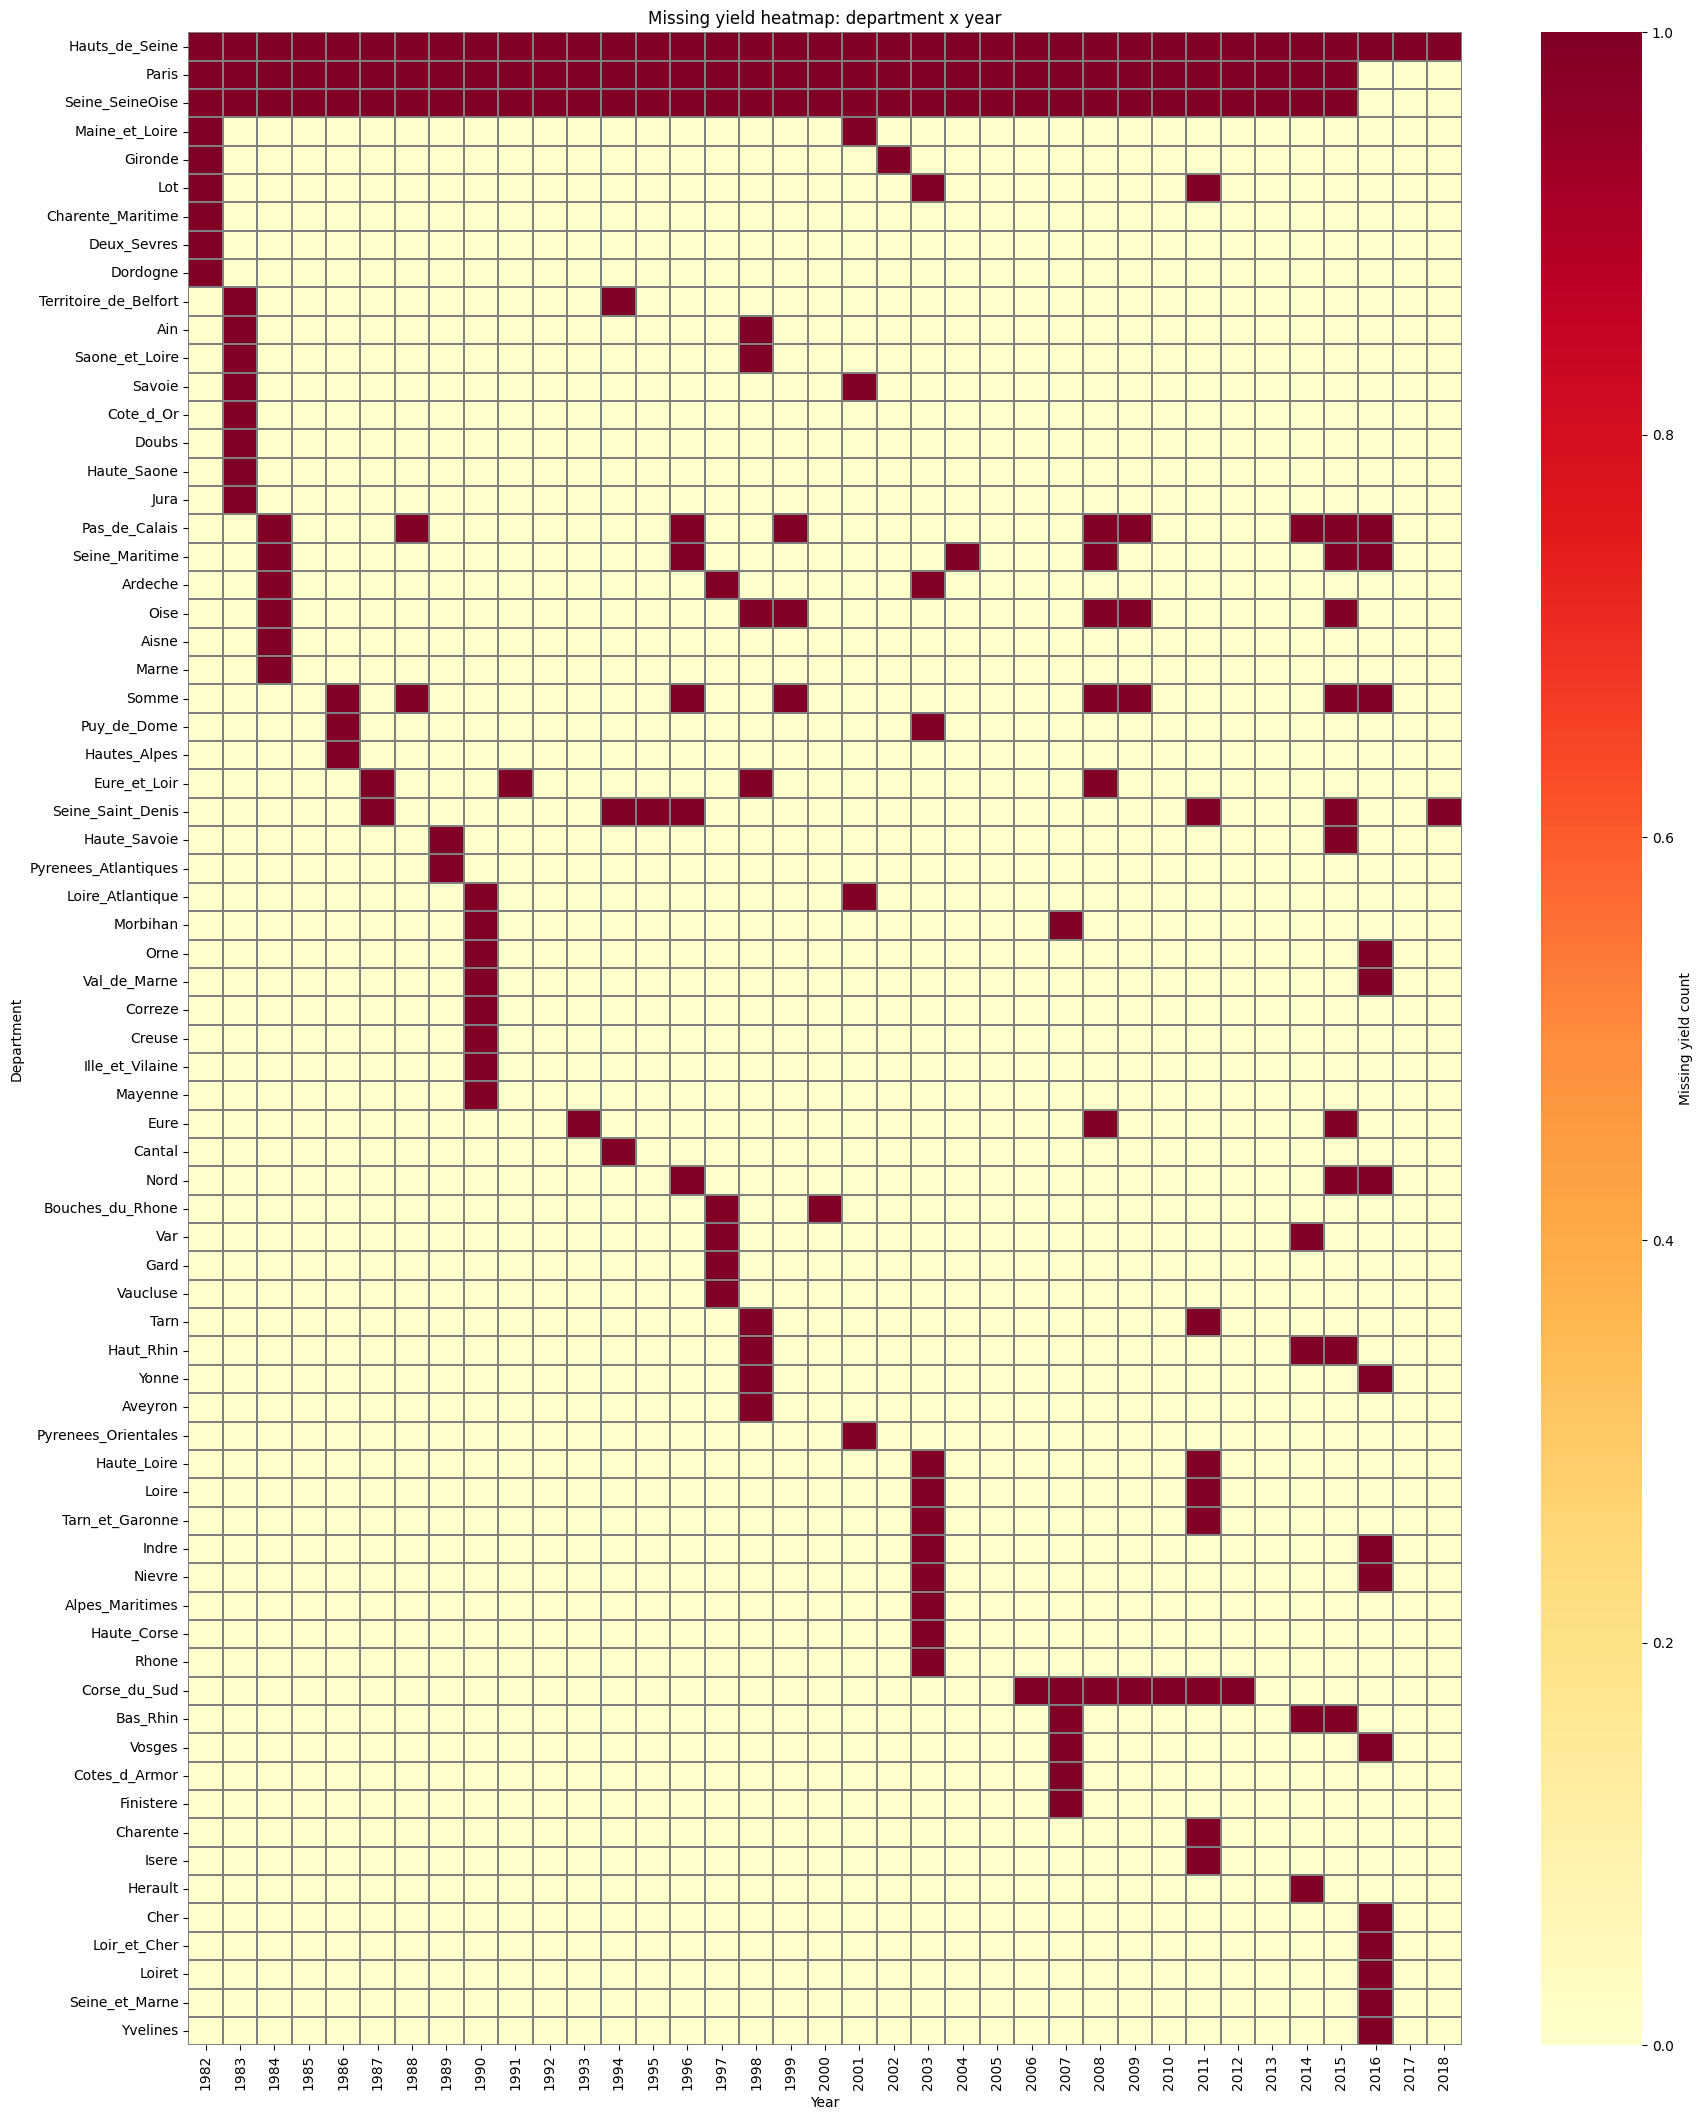

In [13]:
# Create a pivot: department x year, value = 1 if yield present, 0 if missing
pivot = df_yield.pivot_table(
    index="nom_dep", columns="year",
    values="yield", aggfunc=lambda x: x.isna().sum()
).fillna(0)

# Only show departments that have at least 1 missing
pivot_miss = pivot[pivot.sum(axis=1) > 0].sort_values(by=pivot.columns.tolist(), ascending=False)

fig, ax = plt.subplots(figsize=(18, max(6, len(pivot_miss) * 0.3)))
sns.heatmap(pivot_miss, cmap="YlOrRd", linewidths=0.3, linecolor="grey",
            cbar_kws={"label": "Missing yield count"}, ax=ax)
ax.set_title("Missing yield heatmap: department x year")
ax.set_xlabel("Year")
ax.set_ylabel("Department")
plt.tight_layout()
plt.show()

---
## 3. Climate Table — Deep Missing Data Analysis

### 3.1 Overall missing values

In [14]:
print("CLIMATE TABLE — MISSING VALUES PER COLUMN")
print("=" * 60)
for col in df_climate.columns:
    n_miss = df_climate[col].isna().sum()
    pct = 100 * n_miss / len(df_climate)
    print(f"  {col:15s}: {n_miss:8d} missing  ({pct:5.2f}%)")

print(f"\nTotal rows: {len(df_climate):,}")
print(f"Rows with ANY missing: {df_climate.isna().any(axis=1).sum():,}")

CLIMATE TABLE — MISSING VALUES PER COLUMN
  scenario       :        0 missing  ( 0.00%)
  nom_dep        :        0 missing  ( 0.00%)
  code_dep       :        0 missing  ( 0.00%)
  time           :        0 missing  ( 0.00%)
  year           :        0 missing  ( 0.00%)
  metric         :        0 missing  ( 0.00%)
  value          :        0 missing  ( 0.00%)

Total rows: 13,540,116
Rows with ANY missing: 0


### 3.2 Scenario & metric breakdown

In [15]:
print("COVERAGE BY SCENARIO")
print("=" * 60)
for sc in sorted(df_climate["scenario"].unique()):
    sub = df_climate[df_climate["scenario"] == sc]
    y_min, y_max = sub["year"].min(), sub["year"].max()
    n_deps = sub["nom_dep"].nunique()
    n_metrics = sub["metric"].nunique()
    print(f"  {sc:15s}: years {y_min}-{y_max} | {n_deps:3d} departments | {n_metrics} metrics | {len(sub):,} rows")

print("\nMETRICS")
print("=" * 60)
for m in df_climate["metric"].unique():
    n = (df_climate["metric"] == m).sum()
    print(f"  {m}: {n:,} rows")

COVERAGE BY SCENARIO
  historical     : years 1982-2014 |  89 departments | 3 metrics | 3,218,151 rows
  ssp1_2_6       : years 2015-2050 |  89 departments | 3 metrics | 3,510,783 rows
  ssp2_4_5       : years 2015-2050 |  89 departments | 3 metrics | 3,300,399 rows
  ssp5_8_5       : years 2015-2050 |  89 departments | 3 metrics | 3,510,783 rows

METRICS
  near_surface_air_temperature: 4,583,500 rows
  daily_maximum_near_surface_air_temperature: 4,478,308 rows
  precipitation: 4,478,308 rows


### 3.3 Focus on HISTORICAL scenario (training data)

In [16]:
clim_hist = df_climate[df_climate["scenario"] == "historical"].copy()
print(f"Historical climate data: {len(clim_hist):,} rows")
print(f"Departments: {clim_hist['nom_dep'].nunique()}")
print(f"Year range: {clim_hist['year'].min()} - {clim_hist['year'].max()}")
print(f"Metrics: {clim_hist['metric'].unique().tolist()}")

# Check completeness: expected days per (department, year, metric)
days_per_group = clim_hist.groupby(["nom_dep", "year", "metric"]).size().reset_index(name="n_days")
print(f"\nExpected ~365 days per (dept, year, metric)")
display(days_per_group["n_days"].describe())

incomplete = days_per_group[days_per_group["n_days"] < 365]
print(f"\nIncomplete groups (< 365 days): {len(incomplete)}")
if len(incomplete) > 0:
    display(incomplete)

Historical climate data: 3,218,151 rows
Departments: 89
Year range: 1982 - 2014
Metrics: ['near_surface_air_temperature', 'daily_maximum_near_surface_air_temperature', 'precipitation']

Expected ~365 days per (dept, year, metric)


count    8811.000000
mean      365.242424
std         0.428574
min       365.000000
25%       365.000000
50%       365.000000
75%       365.000000
max       366.000000
Name: n_days, dtype: float64


Incomplete groups (< 365 days): 0


### 3.4 Climate departments list

In [17]:
clim_depts = sorted(clim_hist["nom_dep"].unique())
print(f"Historical climate departments ({len(clim_depts)}):")
for i, d in enumerate(clim_depts, 1):
    print(f"  {i:3d}. {d}")

Historical climate departments (89):
    1. Ain
    2. Aisne
    3. Allier
    4. Alpes_Maritimes
    5. Alpes_de_Haute_Provence
    6. Ardeche
    7. Ardennes
    8. Ariege
    9. Aube
   10. Aude
   11. Aveyron
   12. Bas_Rhin
   13. Bouches_du_Rhone
   14. Calvados
   15. Cantal
   16. Charente
   17. Charente_Maritime
   18. Cher
   19. Correze
   20. Cote_d_Or
   21. Cotes_d_Armor
   22. Creuse
   23. Deux_Sevres
   24. Dordogne
   25. Doubs
   26. Drome
   27. Essonne
   28. Eure
   29. Eure_et_Loir
   30. Finistere
   31. Gard
   32. Gers
   33. Gironde
   34. Haut_Rhin
   35. Haute_Garonne
   36. Haute_Loire
   37. Haute_Marne
   38. Haute_Saone
   39. Haute_Savoie
   40. Haute_Vienne
   41. Hautes_Alpes
   42. Hautes_pyrenees
   43. Herault
   44. Ille_et_Vilaine
   45. Indre
   46. Indre_et_Loire
   47. Isere
   48. Jura
   49. Landes
   50. Loir_et_Cher
   51. Loire
   52. Loire_Atlantique
   53. Loiret
   54. Lot
   55. Lot_et_Garonne
   56. Lozere
   57. Maine_et_Loire
   

### 3.5 Coverage per department x year (historical)

In [18]:
# For historical: which (department, year) combos exist?
hist_coverage = clim_hist.groupby(["nom_dep", "year"]).size().reset_index(name="n_rows")
all_years = list(range(1982, 2015))  # historical: 1982-2014
all_combos = pd.MultiIndex.from_product([clim_depts, all_years], names=["nom_dep", "year"])
coverage_full = pd.DataFrame(index=all_combos).reset_index()
coverage_full = coverage_full.merge(hist_coverage, on=["nom_dep", "year"], how="left")
coverage_full["has_data"] = coverage_full["n_rows"].notna()

missing_combos = coverage_full[~coverage_full["has_data"]]
print(f"Missing (dept, year) combinations in historical climate: {len(missing_combos)}")
if len(missing_combos) > 0:
    print("\nMissing combos:")
    display(missing_combos[["nom_dep", "year"]].head(50))

    # By department
    miss_by_dep = missing_combos.groupby("nom_dep").size().sort_values(ascending=False)
    print("\nMissing years per department:")
    display(miss_by_dep.to_frame("n_missing_years"))

Missing (dept, year) combinations in historical climate: 0


### 3.6 Data quality: negative precipitation & value ranges

In [19]:
print("DATA QUALITY BY METRIC (historical only)")
print("=" * 60)
for m in clim_hist["metric"].unique():
    vals = clim_hist[clim_hist["metric"] == m]["value"]
    n_neg = (vals < 0).sum()
    n_inf = np.isinf(vals).sum()
    n_nan = vals.isna().sum()
    print(f"\n  {m}:")
    print(f"    Count: {len(vals):,}")
    print(f"    Range: [{vals.min():.6f}, {vals.max():.6f}]")
    print(f"    Mean: {vals.mean():.6f}, Std: {vals.std():.6f}")
    print(f"    NaN: {n_nan:,}  |  Inf: {n_inf:,}  |  Negative: {n_neg:,} ({100*n_neg/len(vals):.2f}%)")
    if n_neg > 0:
        print(f"    Min negative: {vals[vals < 0].min():.2e}")
        print(f"    Max negative: {vals[vals < 0].max():.2e}")

DATA QUALITY BY METRIC (historical only)

  near_surface_air_temperature:
    Count: 1,072,717
    Range: [246.750824, 304.543335]
    Mean: 283.047028, Std: 7.339863
    NaN: 0  |  Inf: 0  |  Negative: 0 (0.00%)

  daily_maximum_near_surface_air_temperature:
    Count: 1,072,717
    Range: [253.211792, 312.856293]
    Mean: 287.392578, Std: 8.167426
    NaN: 0  |  Inf: 0  |  Negative: 0 (0.00%)

  precipitation:
    Count: 1,072,717
    Range: [0.000000, 0.005103]
    Mean: 0.000096, Std: 0.000183
    NaN: 0  |  Inf: 0  |  Negative: 0 (0.00%)


### 3.7 SSP scenarios: departments & coverage differences

In [20]:
# Check if SSP scenarios have the same departments as historical
print("DEPARTMENT COVERAGE ACROSS SCENARIOS")
print("=" * 60)
scenario_depts = {}
for sc in sorted(df_climate["scenario"].unique()):
    depts = set(df_climate[df_climate["scenario"] == sc]["nom_dep"].unique())
    scenario_depts[sc] = depts
    print(f"  {sc:15s}: {len(depts)} departments")

# Cross-compare
hist_d = scenario_depts["historical"]
for sc in ["ssp1_2_6", "ssp2_4_5", "ssp5_8_5"]:
    diff_from_hist = hist_d - scenario_depts[sc]
    diff_from_ssp = scenario_depts[sc] - hist_d
    print(f"\n  In historical but NOT in {sc}: {sorted(diff_from_hist) if diff_from_hist else 'none'}")
    print(f"  In {sc} but NOT in historical: {sorted(diff_from_ssp) if diff_from_ssp else 'none'}")

DEPARTMENT COVERAGE ACROSS SCENARIOS
  historical     : 89 departments
  ssp1_2_6       : 89 departments
  ssp2_4_5       : 89 departments
  ssp5_8_5       : 89 departments

  In historical but NOT in ssp1_2_6: none
  In ssp1_2_6 but NOT in historical: none

  In historical but NOT in ssp2_4_5: none
  In ssp2_4_5 but NOT in historical: none

  In historical but NOT in ssp5_8_5: none
  In ssp5_8_5 but NOT in historical: none


---
## 4. Department Mismatch — Detailed Analysis

### 4.1 Side-by-side comparison

In [21]:
depts_yield = set(df_yield["nom_dep"].dropna().str.strip().unique())
depts_climate = set(clim_hist["nom_dep"].dropna().str.strip().unique())

in_both = sorted(depts_yield & depts_climate)
in_yield_only = sorted(depts_yield - depts_climate)
in_climate_only = sorted(depts_climate - depts_yield)

print("DEPARTMENT COMPARISON: YIELD vs CLIMATE (historical)")
print("=" * 60)
print(f"  Yield departments     : {len(depts_yield)}")
print(f"  Climate departments   : {len(depts_climate)}")
print(f"  In BOTH (can join)    : {len(in_both)}")
print(f"  In YIELD only         : {len(in_yield_only)}")
print(f"  In CLIMATE only       : {len(in_climate_only)}")

DEPARTMENT COMPARISON: YIELD vs CLIMATE (historical)
  Yield departments     : 97
  Climate departments   : 89
  In BOTH (can join)    : 89
  In YIELD only         : 8
  In CLIMATE only       : 0


In [22]:
if in_yield_only:
    print("DEPARTMENTS IN YIELD ONLY (no climate data):")
    print("=" * 60)
    for d in in_yield_only:
        sub = df_yield[df_yield["nom_dep"].str.strip() == d]
        n_total = len(sub)
        n_yield_ok = sub["yield"].notna().sum()
        mean_yield = sub["yield"].mean()
        mean_area = sub["area"].mean()
        print(f"\n  {d}:")
        print(f"    Rows: {n_total} | Yield present: {n_yield_ok} | Mean yield: {mean_yield:.2f} | Mean area: {mean_area:.0f}")
        print(f"    Years: {sorted(sub['year'].tolist())}")

if in_climate_only:
    print("\nDEPARTMENTS IN CLIMATE ONLY (no yield data):")
    print("=" * 60)
    for d in in_climate_only:
        sub = clim_hist[clim_hist["nom_dep"].str.strip() == d]
        print(f"  {d}: {sub['year'].nunique()} years of climate data")

DEPARTMENTS IN YIELD ONLY (no climate data):

  Corse_du_Sud:
    Rows: 37 | Yield present: 30 | Mean yield: 2.07 | Mean area: 41
    Years: [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

  Haute_Corse:
    Rows: 37 | Yield present: 36 | Mean yield: 2.95 | Mean area: 485
    Years: [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

  Hauts_de_Seine:
    Rows: 37 | Yield present: 0 | Mean yield: nan | Mean area: 0
    Years: [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### 4.2 Fuzzy matching: are the mismatches naming issues?

In [23]:
# Simple fuzzy check: normalize and compare
def normalize_name(name):
    return name.lower().replace("_", " ").replace("-", " ").replace("'", " ").strip()

print("FUZZY MATCHING ATTEMPT")
print("=" * 60)

yield_norm = {normalize_name(d): d for d in depts_yield}
climate_norm = {normalize_name(d): d for d in depts_climate}

# Check if any yield-only dept normalizes to a climate dept
found_match = False
for d in in_yield_only:
    d_norm = normalize_name(d)
    if d_norm in climate_norm:
        print(f"  MATCH: yield '{d}' -> climate '{climate_norm[d_norm]}' (same after normalization)")
        found_match = True
    else:
        # Check substring matches
        for cn, co in climate_norm.items():
            if d_norm in cn or cn in d_norm:
                print(f"  SIMILAR: yield '{d}' ~ climate '{co}'")
                found_match = True

if not found_match:
    print("  No fuzzy matches found — these are genuinely different departments.")

# Also list full sorted dept names side by side
print("\n\nFULL DEPARTMENT LISTS")
print("=" * 60)
all_depts = sorted(depts_yield | depts_climate)
print(f"{'Department':<30s} {'In Yield':>10s} {'In Climate':>10s}")
print("-" * 55)
for d in all_depts:
    in_y = "Yes" if d in depts_yield else "-"
    in_c = "Yes" if d in depts_climate else "-"
    marker = " ***" if in_y != in_c else ""
    print(f"  {d:<28s} {in_y:>10s} {in_c:>10s}{marker}")

FUZZY MATCHING ATTEMPT
  SIMILAR: yield 'Seine_Saint_Denis' ~ climate 'Ain'
  SIMILAR: yield 'Seine_SeineOise' ~ climate 'Oise'
  SIMILAR: yield 'Val_d_Oise' ~ climate 'Oise'
  SIMILAR: yield 'Val_de_Marne' ~ climate 'Marne'


FULL DEPARTMENT LISTS
Department                       In Yield In Climate
-------------------------------------------------------
  Ain                                 Yes        Yes
  Aisne                               Yes        Yes
  Allier                              Yes        Yes
  Alpes_Maritimes                     Yes        Yes
  Alpes_de_Haute_Provence             Yes        Yes
  Ardeche                             Yes        Yes
  Ardennes                            Yes        Yes
  Ariege                              Yes        Yes
  Aube                                Yes        Yes
  Aude                                Yes        Yes
  Aveyron                             Yes        Yes
  Bas_Rhin                            Yes        Yes
  Bouc

### 4.3 Impact quantification

In [24]:
# How many yield rows are affected by the department mismatch?
yield_no_climate = df_yield[df_yield["nom_dep"].str.strip().isin(in_yield_only)]
yield_has_climate = df_yield[df_yield["nom_dep"].str.strip().isin(in_both)]

print("IMPACT OF DEPARTMENT MISMATCH ON YIELD TABLE")
print("=" * 60)
print(f"  Yield rows with climate match    : {len(yield_has_climate)} ({100*len(yield_has_climate)/len(df_yield):.1f}%)")
print(f"  Yield rows WITHOUT climate match : {len(yield_no_climate)} ({100*len(yield_no_climate)/len(df_yield):.1f}%)")
print(f"\n  Of those without climate:")
print(f"    With valid yield  : {yield_no_climate['yield'].notna().sum()}")
print(f"    With missing yield: {yield_no_climate['yield'].isna().sum()}")

IMPACT OF DEPARTMENT MISMATCH ON YIELD TABLE
  Yield rows with climate match    : 3293 (91.9%)
  Yield rows WITHOUT climate match : 290 (8.1%)

  Of those without climate:
    With valid yield  : 168
    With missing yield: 122


---
## 5. Cross-table Join Analysis

### 5.1 Year coverage mismatch

In [25]:
yield_years = set(df_yield["year"].dropna().unique())
climate_hist_years = set(clim_hist["year"].unique())

print("YEAR COVERAGE")
print("=" * 60)
print(f"  Yield years   : {min(yield_years):.0f} - {max(yield_years):.0f} ({len(yield_years)} years)")
print(f"  Climate years : {min(climate_hist_years)} - {max(climate_hist_years)} ({len(climate_hist_years)} years)")
print(f"  Overlap       : {min(yield_years & climate_hist_years):.0f} - {max(yield_years & climate_hist_years):.0f} ({len(yield_years & climate_hist_years)} years)")

yield_no_climate_years = sorted(yield_years - climate_hist_years)
climate_no_yield_years = sorted(climate_hist_years - yield_years)

print(f"\n  Yield years WITHOUT historical climate: {yield_no_climate_years if yield_no_climate_years else 'none'}")
print(f"  Climate years WITHOUT yield           : {climate_no_yield_years if climate_no_yield_years else 'none'}")

if yield_no_climate_years:
    n_affected = df_yield[df_yield["year"].isin(yield_no_climate_years)].shape[0]
    print(f"\n  Yield rows in years without historical climate: {n_affected}")

YEAR COVERAGE
  Yield years   : 1982 - 2018 (37 years)
  Climate years : 1982 - 2014 (33 years)
  Overlap       : 1982 - 2014 (33 years)

  Yield years WITHOUT historical climate: [2015, 2016, 2017, 2018]
  Climate years WITHOUT yield           : none

  Yield rows in years without historical climate: 382


### 5.2 Simulated join: what NaN would we get?

In [26]:
# Aggregate climate to (nom_dep, year) level — simple mean per metric
clim_agg = (
    clim_hist.groupby(["nom_dep", "year", "metric"])["value"]
    .mean()
    .reset_index()
    .pivot_table(index=["nom_dep", "year"], columns="metric", values="value")
    .reset_index()
)
clim_agg.columns.name = None

# Join
merged = df_yield.merge(clim_agg, on=["nom_dep", "year"], how="left")

print("SIMULATED JOIN: yield LEFT JOIN climate_agg")
print("=" * 60)
print(f"  Merged shape: {merged.shape}")
print(f"\n  Missing values after join:")
for col in merged.columns:
    n = merged[col].isna().sum()
    pct = 100 * n / len(merged)
    if n > 0:
        print(f"    {col:45s}: {n:4d} ({pct:5.1f}%)")

SIMULATED JOIN: yield LEFT JOIN climate_agg
  Merged shape: (3583, 9)

  Missing values after join:
    yield                                        :  247 (  6.9%)
    area                                         :  115 (  3.2%)
    production                                   :  122 (  3.4%)
    daily_maximum_near_surface_air_temperature   :  646 ( 18.0%)
    near_surface_air_temperature                 :  646 ( 18.0%)
    precipitation                                :  646 ( 18.0%)


In [27]:
# Diagnose WHY climate columns are NaN
climate_cols = [c for c in merged.columns if c not in df_yield.columns]
any_climate_nan = merged[climate_cols].isna().any(axis=1)

nan_rows = merged[any_climate_nan].copy()
nan_rows["reason"] = "unknown"
nan_rows.loc[nan_rows["nom_dep"].str.strip().isin(in_yield_only), "reason"] = "dept_not_in_climate"
nan_rows.loc[
    (nan_rows["reason"] == "unknown") & (~nan_rows["year"].isin(climate_hist_years)),
    "reason"
] = "year_not_in_climate"

print("REASONS FOR NaN CLIMATE FEATURES AFTER JOIN")
print("=" * 60)
display(nan_rows["reason"].value_counts().to_frame("count"))

if (nan_rows["reason"] == "unknown").sum() > 0:
    print("\nRows with unknown reason for NaN:")
    display(nan_rows[nan_rows["reason"] == "unknown"][["nom_dep", "year"] + climate_cols].head(20))

REASONS FOR NaN CLIMATE FEATURES AFTER JOIN


,count
reason,
year_not_in_climate,356
dept_not_in_climate,290


### 5.3 Summary: rows usable for modeling

In [28]:
has_yield = merged["yield"].notna()
has_climate = merged[climate_cols].notna().all(axis=1)

print("USABLE ROWS SUMMARY")
print("=" * 60)
print(f"  Total yield rows             : {len(merged)}")
print(f"  With yield present           : {has_yield.sum()} ({100*has_yield.mean():.1f}%)")
print(f"  With climate present         : {has_climate.sum()} ({100*has_climate.mean():.1f}%)")
print(f"  With BOTH yield AND climate  : {(has_yield & has_climate).sum()} ({100*(has_yield & has_climate).mean():.1f}%)")
print(f"\n  Lost due to missing yield   : {(~has_yield).sum()}")
print(f"  Lost due to missing climate  : {(has_yield & ~has_climate).sum()}")
print(f"  Lost total (from original)   : {len(merged) - (has_yield & has_climate).sum()}")

USABLE ROWS SUMMARY
  Total yield rows             : 3583
  With yield present           : 3336 (93.1%)
  With climate present         : 2937 (82.0%)
  With BOTH yield AND climate  : 2835 (79.1%)

  Lost due to missing yield   : 247
  Lost due to missing climate  : 501
  Lost total (from original)   : 748


---
## 6. Summary of All Issues — Decision Points

Below is a consolidated summary of every data quality issue found. We can discuss each one and decide what to do.

In [29]:
print("""
╔══════════════════════════════════════════════════════════════════════════════════════╗
║                    SUMMARY OF ALL DATA QUALITY ISSUES                              ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

YIELD TABLE
──────────────────────────────────────────────────────────────────────────────────────
Issue #1: Missing yield values
  - 247 rows (~6.9%) have NaN yield
  - ~125 can be RECOVERED via yield = production / area
  - ~122 cannot be recovered (area and/or production also missing)
  → DECISION: Recover where possible? Drop the rest?

Issue #2: Missing area values
  - 115 rows (~3.2%) have NaN area
  - Most overlap with missing yield
  → DECISION: Drop? Or keep rows where yield is present even if area is NaN?

Issue #3: Missing production values
  - 122 rows (~3.4%) have NaN production
  → DECISION: Same as area — keep if yield is present?

Issue #4: Departments with extremely high missing rates
  - Paris, Hauts-de-Seine, Seine-Saint-Denis, Val-de-Marne, Val-d'Oise, 
    Seine-et-Marne (urban Île-de-France) → minimal barley production
  → DECISION: Drop these departments entirely?

Issue #5: Area = 0 or very small areas
  - Some rows have area = 0 (no barley cultivation)
  → DECISION: Drop rows with area = 0?

Issue #6: Yield outliers
  - Some extreme low values (< 1 t/ha)
  → DECISION: Keep, clip, or investigate?

CLIMATE TABLE
──────────────────────────────────────────────────────────────────────────────────────
Issue #7: No raw NaN values
  - Climate data has 0% missing → good!
  → No action needed on raw missing.

Issue #8: Negative precipitation values
  - ~4% of precipitation rows have tiny negative values (~1e-25)
  - These are numerical noise, not real
  → DECISION: Clip to 0?

Issue #9: Temperature in Kelvin
  - Values are in Kelvin (not Celsius)
  → DECISION: Convert to Celsius (subtract 273.15)? Or keep in K?

CROSS-TABLE ISSUES
──────────────────────────────────────────────────────────────────────────────────────
Issue #10: Department mismatch
  - 8 departments in yield have NO climate data
  - These are: Corse_du_Sud, Haute_Corse, Hauts_de_Seine, Paris, 
    Seine_Saint_Denis, Seine_SeineOise, Val_d_Oise, Val_de_Marne
  - Affects ~290 yield rows (8.1%)
  - No fuzzy name matches → genuinely missing, not a naming issue
  → DECISION: Drop yield rows for these departments?

Issue #11: Year coverage mismatch
  - Yield: 1982-2018, Climate historical: 1982-2014
  - Yield rows for 2015-2018 have no historical climate data
  - SSP scenarios start at 2015 (future projections, not observations)
  → DECISION: Drop yield rows 2015-2018? Or use SSP data as proxy?

""")


╔══════════════════════════════════════════════════════════════════════════════════════╗
║                    SUMMARY OF ALL DATA QUALITY ISSUES                              ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

YIELD TABLE
──────────────────────────────────────────────────────────────────────────────────────
Issue #1: Missing yield values
  - 247 rows (~6.9%) have NaN yield
  - ~125 can be RECOVERED via yield = production / area
  - ~122 cannot be recovered (area and/or production also missing)
  → DECISION: Recover where possible? Drop the rest?

Issue #2: Missing area values
  - 115 rows (~3.2%) have NaN area
  - Most overlap with missing yield
  → DECISION: Drop? Or keep rows where yield is present even if area is NaN?

Issue #3: Missing production values
  - 122 rows (~3.4%) have NaN production
  → DECISION: Same as area — keep if yield is present?

Issue #4: Departments with extremely high missing rates
  - Paris, Hauts-de-Se

In [30]:
# Final quantification: how many rows would survive each cleaning scenario
total = len(df_yield)

# Scenario A: minimal cleaning (just drop rows where yield is NaN after recovery)
df_a = df_yield.copy()
recover_mask = df_a["yield"].isna() & df_a["area"].notna() & df_a["production"].notna() & (df_a["area"] > 0)
df_a.loc[recover_mask, "yield"] = df_a.loc[recover_mask, "production"] / df_a.loc[recover_mask, "area"]
a_after_recovery = df_a["yield"].notna().sum()
a_lost = total - a_after_recovery

# Scenario B: + drop departments not in climate
df_b = df_a[df_a["nom_dep"].str.strip().isin(in_both)]
b_after = df_b["yield"].notna().sum()

# Scenario C: + drop years not in historical climate (2015-2018)
df_c = df_b[df_b["year"].isin(climate_hist_years)]
c_after = df_c["yield"].notna().sum()

# Scenario D: + drop area = 0
df_d = df_c[df_c["area"] > 0]
d_after = df_d["yield"].notna().sum()

print("CLEANING SCENARIOS — ROW SURVIVAL")
print("=" * 60)
print(f"  Original                                  : {total:5d} rows")
print(f"  A) Recover yield + drop NaN yield         : {a_after_recovery:5d} rows (lost {a_lost})")
print(f"  B) + Drop depts not in climate            : {b_after:5d} rows")
print(f"  C) + Drop years 2015-2018 (no hist clim)  : {c_after:5d} rows")
print(f"  D) + Drop area = 0                        : {d_after:5d} rows")
print(f"\n  Final usable rows: {d_after} out of {total} ({100*d_after/total:.1f}%)")

CLEANING SCENARIOS — ROW SURVIVAL
  Original                                  :  3583 rows
  A) Recover yield + drop NaN yield         :  3461 rows (lost 122)
  B) + Drop depts not in climate            :  3289 rows
  C) + Drop years 2015-2018 (no hist clim)  :  2935 rows
  D) + Drop area = 0                        :  2935 rows

  Final usable rows: 2935 out of 3583 (81.9%)
